In [1]:
import numpy as np
import pandas as pd
import requests
import re
from math import radians, cos, sin, asin, sqrt

In [2]:
pd.options.display.max_columns = 150

### Cycling through the rain

In this notebook I'm exploring the weather during my daily commute by bike from Haarlem to Hoofddorp-Zuid and how often it rains during my commuting time. In this notebook I use the KNMI data (Royal Dutch Meteorological Institute or Dutch Met Office), extracted from the API. I will be leaving my house at 8 o'clock in the AM and returning on 5 o'clock in the PM.

First, let's find out what our closest weather station is for both our home and work locations!

In [3]:
# set parameters and KNMI API url
knmi_api_url = 'http://projects.knmi.nl/klimatologie/uurgegevens/getdata_uur.cgi'

# download only data from hour 9 (8:00 - 9:00 AM) to hour 18 (5:00 - 6:00 PM)
params = {'start': '2018010109', 'end: '', stns': 'ALL'}

In [4]:
# define last day of the last passed month and define a fixed end date
last_day_of_last_month = pd.Timestamp.now() - pd.Timedelta(days = int(pd.Timestamp.now().strftime('%d')) + 1)
last_day_of_last_month = last_day_of_last_month.strftime('%Y%m%d')
params['end'] = last_day_of_last_month + '18'

In [5]:
# extract data from API
knmi_response = requests.get(knmi_api_url, params = params)

# extract text from API response
knmi_response = knmi_response.text

# split API response on line breaks
knmi_response = knmi_response.split('\r\n')

In [6]:
knmi_response[:100]

['# BRON: KONINKLIJK NEDERLANDS METEOROLOGISCH INSTITUUT (KNMI)',
 '# Opmerking: door stationsverplaatsingen en veranderingen in waarneemmethodieken zijn deze tijdreeksen van uurwaarden mogelijk inhomogeen! Dat betekent dat deze reeks van gemeten waarden niet geschikt is voor trendanalyse. Voor studies naar klimaatverandering verwijzen we naar de gehomogeniseerde reeks maandtemperaturen van De Bilt <http://www.knmi.nl/klimatologie/onderzoeksgegevens/homogeen_260/index.html> of de Centraal Nederland Temperatuur <http://www.knmi.nl/klimatologie/onderzoeksgegevens/CNT/>.',
 '# ',
 '# ',
 '# STN      LON(east)   LAT(north)     ALT(m)  NAME',
 '# 391:         6.197       51.498      19.50  ARCEN',
 '# 370:         5.377       51.451      22.60  EINDHOVEN',
 '# 331:         4.193       51.480       0.00  THOLEN',
 '# 315:         3.998       51.447       0.00  HANSWEERT',
 '# 324:         4.006       51.596       0.00  STAVENISSE',
 '# 375:         5.707       51.659      22.00  VOLKEL',
 '#

In [7]:
# extract station id, longitude, latitude and station city name
knmi_stations_cleaned = []

for line in knmi_response:
    if re.match('^.\s\d{3}\:\s+', line) is not None:
        station = re.sub('(#\s|:)', '', line)
        knmi_stations_cleaned.append(re.split('\s{2,}', station))

In [8]:
# check results
knmi_stations_cleaned[:5]

[['391', '6.197', '51.498', '19.50', 'ARCEN'],
 ['370', '5.377', '51.451', '22.60', 'EINDHOVEN'],
 ['331', '4.193', '51.480', '0.00', 'THOLEN'],
 ['315', '3.998', '51.447', '0.00', 'HANSWEERT'],
 ['324', '4.006', '51.596', '0.00', 'STAVENISSE']]

In [9]:
# define home and work locations with longitudes and latitudes
home_long = 52.377797984842694
home_lat = 4.656652974122819
work_long = 52.2882321
work_lat = 4.6794414

In [10]:
def distance(lat1, lon1, lat2, lon2): 
    """This function returns the distance (as the crow flies) in kilometers from GPS coordinates""" 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result 
    return(c * r)

In [11]:
# calculate distance between home/work location and all weather stations and append station when distance is smaller
closest_station_to_home = 1000
closest_station_to_work = 1000
closest_station_to_home_list = []
closest_station_to_work_list = []

for station in knmi_stations_cleaned:
    station_long = float(station[2])
    station_lat = float(station[1])
    distance_home_station = distance(station_long, station_lat, home_long, home_lat)
    distance_work_station = distance(station_long, station_lat, work_long, work_lat)
    if closest_station_to_home > distance_home_station:
        closest_station_to_home = distance_home_station
        closest_station_to_home_list.append(station)
    if closest_station_to_work > distance_work_station:
        closest_station_to_work = distance_work_station
        closest_station_to_work_list.append(station)

In [12]:
# check if the location from the closest weather station to my home is equal to the closest weather station to work
print(closest_station_to_home_list[-1] == closest_station_to_work_list[-1])

# print closest weather station
print(closest_station_to_home_list[-1])

True
['240', '4.790', '52.318', '-3.30', 'SCHIPHOL']


In [13]:
# extract weather data
knmi_weather_data = []

for line in knmi_response:
    if re.match('^\s+[0-9]{3},20[0-9]{6}.*', line):
        cleaned_line = re.sub('\s+', '', line)
        knmi_weather_data.append(cleaned_line.split(','))

In [14]:
knmi_weather_data[:3]

[['391',
  '20180101',
  '9',
  '220',
  '70',
  '60',
  '120',
  '65',
  '',
  '30',
  '2',
  '11',
  '0',
  '0',
  '',
  '',
  '',
  '78',
  '',
  '6',
  '',
  '',
  '',
  '',
  ''],
 ['391',
  '20180101',
  '10',
  '220',
  '70',
  '70',
  '140',
  '69',
  '',
  '38',
  '7',
  '43',
  '0',
  '0',
  '',
  '',
  '',
  '80',
  '',
  '6',
  '',
  '',
  '',
  '',
  ''],
 ['391',
  '20180101',
  '11',
  '220',
  '80',
  '80',
  '130',
  '77',
  '',
  '36',
  '8',
  '74',
  '0',
  '0',
  '',
  '',
  '',
  '75',
  '',
  '6',
  '',
  '',
  '',
  '',
  '']]

#### Putting data in pandas dataframe and cleaning

In [15]:
# define cols, extracted from original KNMI API response
cols = 'STN,YYYYMMDD,   HH,   DD,   FH,   FF,   FX,    T, T10N,   TD,   SQ,    Q,   DR,   RH,    P,   VV,    N,    U,   WW,   IX,    M,    R,    S,    O,    Y'
cols = [re.sub('\s+', '', x) for x in cols.split(',')]

# put data in dataframe
df_knmi = pd.DataFrame(knmi_weather_data, columns = cols)

# change empty values to NaN values
df_knmi.replace('', np.nan, inplace = True)

# drop unnecessary columns
df_knmi = df_knmi[['STN','YYYYMMDD','HH', 'DR', 'RH']].copy()

# rename column names for better understanding of columns
df_knmi.rename({'STN':'station_id','YYYYMMDD':'date', 'HH': 'hour', 'DR': 'percipation_duration', 'RH': 'percipation_amount'}, inplace=True, axis=1)

# remove all data but data from the closest KNMI weather station (Schiphol)
df_knmi = df_knmi[df_knmi['station_id'] == closest_station_to_home_list[-1][0]].copy()

# date column to pandas datetime
df_knmi['date'] = df_knmi['date'].apply(lambda x: pd.to_datetime(x))

# remove weekend days
df_knmi = df_knmi[df_knmi['date'].dt.dayofweek < 5].copy()

# calculate quarter
df_knmi['quarter'] = df_knmi['date'].dt.quarter

#convert percipation amount to integers
df_knmi.loc[:, 'percipation_duration':] = df_knmi.loc[:, 'percipation_duration':].astype(int)

# remove negative values from percipation amount column
df_knmi['percipation_amount'].replace(-1, 0, inplace = True)

# set hour values to more intuitive values (counting from zero instead of one)
df_knmi['hour'] = df_knmi['hour'].astype(int) - 1

# remove unused hours
df_knmi = df_knmi[df_knmi['hour'].isin([8, 17])].copy()

In [16]:
def f(num):
    """"Takes in integer and returns factorial (e.g. 5! or 5*4*3*2*1) for this integer. Used only for improved readibility of code"""
    return np.math.factorial(num)

In [17]:
def nCr(n, r):
    """" Calculates possible combinations that can be obtained by taking a sample of items from a larger set. 
    The order of the items chosen in the subset does not matter."""
    return f(n) / (f(r) * f(n - r))

In [18]:
def getting_wet(rain_intervals, intervals = 10, cycling_intervals = 7):
    """Takes in six minute rain intervals per hour and cycling times in six minute intervals and
    returns a chance of rain during the commute."""
    try:
        # calculate dry intervals
        dry_intervals = intervals - rain_intervals
        
        # calculate possible outcomes
        possible_outcomes = nCr(intervals, cycling_intervals)
        
        # calculate chance of staying dry
        dry = nCr(dry_intervals, cycling_intervals)
        
        # calculate the chance of not getting rain
        no_rain = nCr(rain_intervals, 0)
        
        # return the inverse of the chance of staying dry
        return 1 - ((dry * no_rain) / possible_outcomes)
    
    except:
        return 1

In [19]:
# calculate the chance of getting wet during my commute
df_knmi['rain_chance'] = df_knmi['percipation_duration'].apply(lambda x: getting_wet(x))

In [20]:
# return random boolean based on column rain_chance for getting wet or not
df_knmi['got_wet'] = df_knmi['rain_chance'].apply(lambda x: bool(np.random.binomial(1, x)))

In [21]:
mean_wet_commutes = df_knmi['got_wet'].mean()

print(f'The percentage of commutes where I actually get wet is {round(mean_wet_commutes * 100, 1)}%')

The percentage of commutes where I actually get wet is 10.3%


In [22]:
# plot data per month, year
ax = df_knmi.groupby([df_knmi['date'].dt.year, df_knmi['date'].dt.month])['got_wet'].mean().plot(kind = 'bar', figsize = (12,4), label = 'Percentage got wet', title = 'Percentage got wet per year, month')

# plot axhline with average of wet commutes
ax.axhline(mean_wet_commutes, c = 'tab:orange', linestyle = ':', label = 'Avg. of commutes with rain')

# show labels
ax.legend()

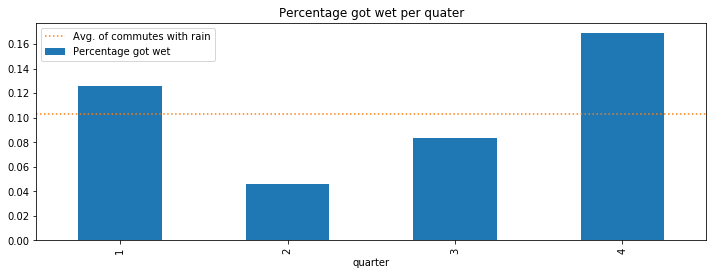

In [23]:
# plot data per quarter
ax = df_knmi.groupby('quarter')['got_wet'].mean().plot(kind = 'bar', figsize = (12,4), label = 'Percentage got wet', title = 'Percentage got wet per quater')

# plot axhline with average of wet commutes
ax.axhline(mean_wet_commutes, c = 'tab:orange', linestyle = ':', label = 'Avg. of commutes with rain')

# show labels
ax.legend()

### Conclusion

On my daily commute I have a slight chance of getting wet, around 10-11%. There is a large difference between months and quarters. Especially quarters 2 and 3 (from April to September) have significantly lower chances of rainfall during my commute. 

In quarter 2 (April - June) my chance of getting wet during my commute is less than 5%, which means that on average I only get wet once per month in this quarter.